In [1]:
import sys
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
# File metadata
TID = 0
AUD_MAP_TYPE = 'discrete'
HVC_COND = 'developing_hvc'
REC_PLASTICITY = 'EE'
postfix = '%s_map_%s_%s_%s' % \
          (AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, TID)

## Loading

In [3]:
### Constants
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
tauE, tauI, dt = 30, 10, 1

### EI transfer function parameters
rEmax, rImax, thE, thI, slope = 50, 100, 0, 0, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * slope)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * slope)))

### FF transfer function parameters
r_rest = 2 # target rate when phi(0)
thFF = -erfinv(r_rest * 2 / rEmax - 1) * (np.sqrt(2) * slope)
phi = lambda x: rEmax/2 * (1 + erf((x - thFF) / (np.sqrt(2) * slope)))

In [4]:
netFF, netEI, netEIrec, aud_mapping = load_models('results/', AUD_MAP_TYPE, REC_PLASTICITY,
                                                  HVC_COND, TID)
netFF.phiE = phi
netEI.phiE, netEI.phiI = phiE, phiI
netEIrec.phiE, netEIrec.phiI = phiE, phiI

[Text(0, 0.5, 'auditory input neuron'), Text(0.5, 0, 'excitatory neuron')]

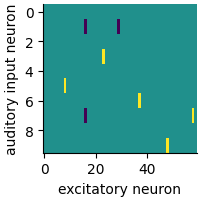

In [5]:
fname = 'realistic_auditory_processing/learned_song_responses.npz'
aud_real, _ = read_realistic_input(fname, NE, mean=2, scale=3, mapping=aud_mapping, mapping_args=None)
fig, ax = plt.subplots(1, figsize=(2,2))
ax.imshow(aud_mapping[:10,:60], interpolation='none', aspect='auto')
ax.set(ylabel='auditory input neuron', xlabel='excitatory neuron')

In [6]:
### Time window of perturbation
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

### Constants related to time
T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

### Generate auditory inputs for training
aud, aud_idx = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)

### Generate HVC activities for training
_ = np.arange(N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
save_W_ts = np.round(burst_ts[-1]).astype(int)
rH = generate_HVC(T, burst_ts, PEAK_RATE+_*0.1, KERNEL_WIDTH+_*0.01)

## Testing

In [7]:
N_test_rend = 20
T_test = T_burn+T_rend
T_pre = 100 # time period to keep before song
args = (N_test_rend, T_burn, T_post, None, False)
aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *args)
aud_pert_weak, aud_pert_idx = generate_realistic_aud(aud_real['pert_weak'], *args)
aud_pert_strong, _ = generate_realistic_aud(aud_real['pert_strong'], *args)
cases = ('ctrl', 'pert_weak', 'pert_strong', 'deaf', 'playback')

In [8]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# 3 lists for 3 models
res = {k: [np.zeros((N_test_rend,T_pre+T_rend,NE+i)) for i in (0,NI,NI)] for k in cases} 
for k, a in zip(cases, (aud_ctrl, aud_pert_weak, aud_pert_strong, aud_ctrl*0, aud_ctrl)):
    for i in tqdm(range(a.shape[0])): # for each case, enumerate over songs
        rH_ = rH[:T_test] if k != 'playback' else rH[:T_test]*0
        args = dict(rH=rH_, aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                    noise_strength=1, no_progress_bar=True)
        res[k][0][i] = np.hstack(netFF.sim(hE0, **args)[:1])[T_burn-T_pre:]
        res[k][1][i] = np.hstack(netEI.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]
        res[k][2][i] = np.hstack(netEIrec.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|███████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


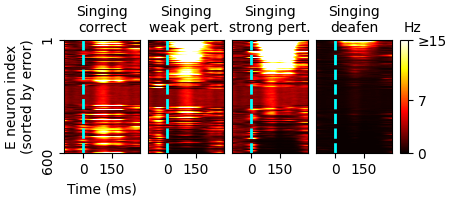

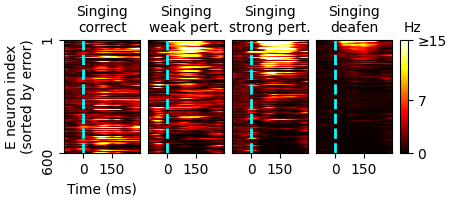

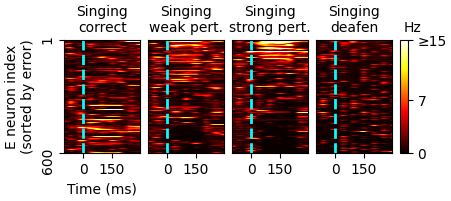

In [9]:
i = 0
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'EI', 'EIrec')):
    _ = [res[k][l][i,:,:NE] for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    t0, t1 = int(aud_real['pert_t0'][i]) + T_pre, int(aud_real['pert_t1'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t1].mean(axis=1)
    bos_weak_pert = aud_real['pert_weak'][i,:,t0:t1].mean(axis=1)
    bos_strong_pert = aud_real['pert_strong'][i,:,t0:t1].mean(axis=1)
    err = [bos_ctrl - syl, bos_weak_pert - syl, bos_strong_pert - syl, -syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t1+250,
                                       figsize=(4.5, 2), plot_z=False, sort_by='e', th=15, tpre=100) 
    for j in range(len(ax)-1):
        ax[j].set(xticks=[100, 250], xticklabels=[0, 150], xlabel='')
    ax[0].set(xlabel='Time (ms)')
    fig.savefig('svg/err_response_%s_%s.svg' % (m, postfix), transparent=True)

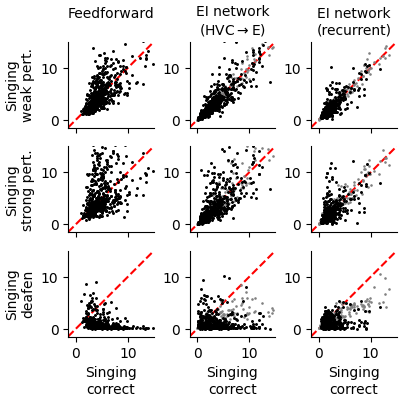

In [11]:
fig, ax = plt.subplots(3, 3, sharex='col', sharey='col', figsize=(4, 4))
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i in range(3): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    for j, k in enumerate(('pert_weak', 'pert_strong', 'deaf')):
        z_pert = res[k][i][:,t0:t1].mean(axis=(0,1))
        ax[j,i].scatter(z_ctrl[NE:], z_pert[NE:], s=3, c='grey')
        ax[j,i].scatter(z_ctrl[:NE], z_pert[:NE], s=5, c='k')
        ax[j,i].plot([-3, 20], [-3,20], c='r', ls='--', zorder=-1)
        ax[j,i].set(aspect=1, ylim=[-1.5,15], xlim=[-1.5,15], 
                    yticks=[0,10], xticks=[0,10])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nweak pert.')
ax[1,0].set_ylabel('Singing\nstrong pert.')
ax[2,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(recurrent)', fontsize=10)
fig.savefig('svg/learn_real_joint_dist_%s.svg' % postfix)

Text(0.5, 0.98, 'PC1 vs PC2')

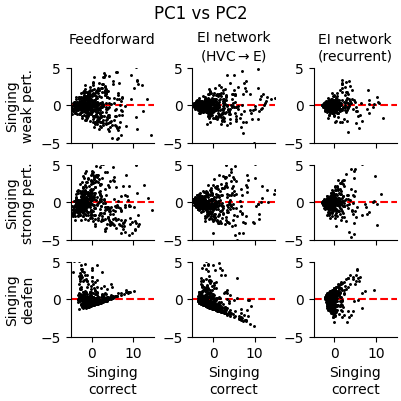

In [12]:
from sklearn.decomposition import PCA
fig, ax = plt.subplots(3, 3, sharex='col', sharey='col', figsize=(4, 4))
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song
for i in range(3): 
    z_ctrl = res['ctrl'][i][:,t0:t1].mean(axis=(0,1))
    for j, k in enumerate(('pert_weak', 'pert_strong', 'deaf')):
        z_pert = res[k][i][:,t0:t1].mean(axis=(0,1))
        z1, z2 = PCA().fit_transform(np.stack((z_ctrl, z_pert),1)).T
        z1 = -z1 if (z1**3).mean() < 0 else z1
        z2 = -z2 if (z2**3).mean() < 0 else z2
        # z1, z2 = (z_pert/2 + z_ctrl/2), (z_pert/2 - z_ctrl/2)
        ax[j,i].axhline(0, ls='--', c='r', zorder=-1)
        # ax[j,i].scatter(z1[NE:], z2[NE:], s=3, c='grey')
        ax[j,i].scatter(z1[:NE], z2[:NE], s=5, c='k')
        ax[j,i].set(ylim=[-4,4], xlim=[-5,15], 
                    yticks=[-5, 0, 5], xticks=[0,10])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nweak pert.')
ax[1,0].set_ylabel('Singing\nstrong pert.')
ax[2,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(recurrent)', fontsize=10)
fig.suptitle('PC1 vs PC2')
# fig.suptitle('Rotate by 45 degree clockwise')

[np.float64(0.1378), np.float64(0.053), np.float64(0.0002), np.float64(0.0002)]
[np.float64(0.1368), np.float64(0.7332), np.float64(0.0002), np.float64(0.0002)]
[np.float64(0.8722), np.float64(0.2782), np.float64(0.0002), np.float64(0.0002)]


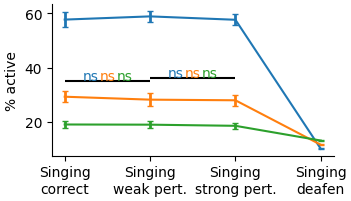

In [13]:
from scipy.stats import permutation_test
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
fig, ax = plt.subplots(1, figsize=(3.5, 2))
ax.hlines([35, 36], [0, 1], [1, 2], color='k')
def statistic(x, y):
    return x.mean() - y.mean()
for l, m in enumerate(('FF', 'EI', 'EIrec')):
    color = 'C%d' % l
    t0, t1 = PERT_T0+T_pre, PERT_T1+T_pre
    data = [(res[k][l][:,t0:t1,:NE].mean(axis=1)>3).mean(axis=-1)*100
            for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = np.stack(data)
    ax.errorbar([0,1,2,3], data.mean(axis=1), yerr=data.std(axis=1), 
                capsize=2, elinewidth=2)
    pvs = [permutation_test(data[0:2], statistic).pvalue, 
           permutation_test(data[1:3], statistic).pvalue,
           permutation_test([data[0],data[3]], statistic).pvalue,
           permutation_test([data[0],data[3]], statistic).pvalue]
    print(pvs)
    for i, pv in enumerate(pvs[:-2]):
        if pv * 2 < 0.05:
            ax.text(i+0.5+(l-1)*0.2, 35+i if i<2 else 34, 
                    '*' if pv * 2 > 0.01 else '**', ha='center', c='C%d'%l)
        else:
            ax.text(i+0.5+(l-1)*0.2, 35.5+i if i<2 else 34.5, 
                    'ns', ha='center', c='C%d'%l)
ax.set(xticks=[0,1,2,3], xticklabels=titles, ylabel='% active')
fig.savefig('svg/percent_active_%s.svg' % postfix)

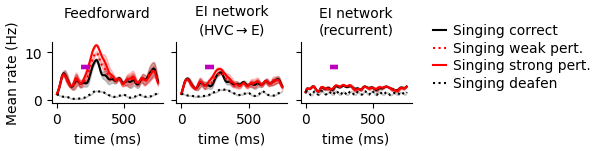

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(6,1.5), sharey='all')
for i, k in enumerate(('Feedforward\n', 'EI network\n(HVC$\\to$E)', 
                       'EI network\n(recurrent)')):
    for j, c in zip(('ctrl', 'pert_weak', 'pert_strong', 'deaf'), ('k', 'r', 'r', 'k')):
        aux = res[j][i][:,T_pre:-T_post-50].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, 
                      ls='-' if j in ('ctrl', 'pert_strong') else ':')
        ax[i].hlines(7, aud_real['pert_t0'].mean()-aud_real['pert_t0'].std(), 
                        aud_real['pert_t1'].mean()+aud_real['pert_t1'].std(),
                     lw=3, color='m')
    ax[i].set(xlabel='time (ms)', title=k)
ax[0].set_ylabel('Mean rate (Hz)')
ax[-1].set_axis_off() # dummy
for k, c in zip(('correct', 'weak pert.', 'strong pert.', 'deafen'), ('k', 'r', 'r', 'k')):
    ax[-1].plot(0,0, c=c, ls='-' if k in ('correct', 'strong pert.') else ':', label='Singing '+k)
ax[-1].legend()
fig.savefig('svg/learn_real_mean_rates_%s.svg' % postfix)

In [15]:
def plot_raster(model1, model2, mname1, mname2, NE, cond_names, 
                t0, t1, t_on, t0_pert, t1_pert):
    '''
    model1, model2: lists of neuron responses over time
    mname1, mname2: model names
    is_ff: 2-tuple specifying if model1 or 2 is EI network or not
    t0, t1: time window to plot
    t_on: song onset. Must be > 0 for sorting to work
    t0_pert, t1_pert: time window of perturbated syl
    '''
    # width and height ratios
    hr = [[1, 0.5] if md[0].shape[1]>NE else [1] for md in (model1, model2)]
    hr = hr[0] + [0.1] + hr[1] + [0.5]
    wr = [1]*len(model1) + [0.1]
    i_null = 1 + int(model1[0].shape[1]>NE)

    # preprocess data; zs has rows and cols corresponding to the img layout
    zs = []
    for md in (model1, model2):
        mean = [m.mean(axis=0)[None,:] for m in md]
        std = [m.std(axis=0)[None,:] for m in md]
        zs.append([(m[t0:t1,:NE]-a[:,:NE])/s[:,:NE] for m, a, s in zip(md, mean, std)])
        if md[0].shape[1]>NE: # Inh. as well
            zs.append([(m[t0:t1,NE:]-a[:,NE:])/s[:,NE:] for m, a, s in zip(md, mean, std)])
        zs.append(None) # For white space row
    zmin, zmax = 1e10, -1e10
    for zp in zs:
        if zp is None:
            continue
        zmin_, zmax_ = min(list(map(lambda x: x.min(), zp))), max(list(map(lambda x: x.max(), zp)))
        zmin = zmin_ if zmin > zmin_ else zmin # update
        zmax = zmax_ if zmax < zmax_ else zmax
    zmin, zmax = max(zmin, -3), min(zmax, 5)
    norm = TwoSlopeNorm(0, zmin, zmax)
    
    fig, ax = plt.subplots(len(hr), len(wr), figsize=(6, 4), width_ratios=wr, height_ratios=hr)
    for i in range(ax.shape[1]):
        ax[i_null,i].set_axis_off()
    ax[-1,-1].set_axis_off()

    #### Plotting ####
    ls = [] # for legend in the last row
    for i, zp in enumerate(zs): # row
        if zp is None:
            continue
        p = 'Exc.' if hr[i] == 1 else 'Inh.'

        # sort by the first one
        idx = temporal_sort(zp[0], 'dmean', t0=t_on)[1]

        for j, (z, l) in enumerate(zip(zp, cond_names)): 
            # plot heatmap
            im = ax[i,j].imshow(z[:,idx].T, aspect='auto', cmap='seismic', 
                                interpolation='none', norm=norm, rasterized=True)
            ax[i,j].axvline(t_on, ls='--', c='k', lw=2)
            ax[i,j].set(xticks=[], yticks=[])
            ax[0,j].set_title(l, fontsize=10, va='bottom')

            if p == 'Exc.': # plot % active in the last row
                c, label = ('C0',mname1) if i<i_null else ('C1',mname2)
                peaks = (z > 1).mean(axis=1) * 100
                l, = ax[-1,j].plot(peaks, color=c, label=label)
                if j == 0: # for legend
                    ls.append(l)
                ax[-1,j].axvline(t_on, ls='--', c='k', lw=2)
                ax[-1,j].set(xlim=[0,len(peaks)], yticks=[], xlabel='Time (ms)', 
                             xticks=[t_on, 800], xticklabels=[0, 800-t_on])
                
        if i != 0:
            ax[i,-1].set_axis_off()
        ax[i,0].set(ylabel='\n'+p, yticks=[])

    #### Color bar and labels ####
    cbar = fig.colorbar(im, cax=ax[0,-1])
    # cbar.set_ticks([np.ceil(zmin), 0, np.floor(zmax)-1])
    cbar.set_ticks([np.ceil(zmin), 0, np.floor(zmax)])
    fig.text(0.025, 0.8, mname1, rotation=90, ha='center', va='center')
    fig.text(0.025, 0.45, mname2, rotation=90, ha='center', va='center')
    # last row
    fig.legend(handles=ls, loc=(0.5, 0.22), ncols=2)
    ax[-1,0].set(yticks=[0, 40], ylabel='% excited', title='\n')
    
    #### Plot perturbed syl indicator ####
    for i in (0, -1):
        _ = max(ax[i,1].get_ylim())
        y0, height = _ * (-0.05 if i==0 else 1.05) , _ / 20 * (1 - i)
        ax[i,1].add_patch(plt.Rectangle((t0_pert, y0), t1_pert-t0_pert, height, fc='k', 
                                         clip_on=False, linewidth=0))
    return fig, ax

502 98
443 157
77 73
443 157
77 73
508 92
94 56


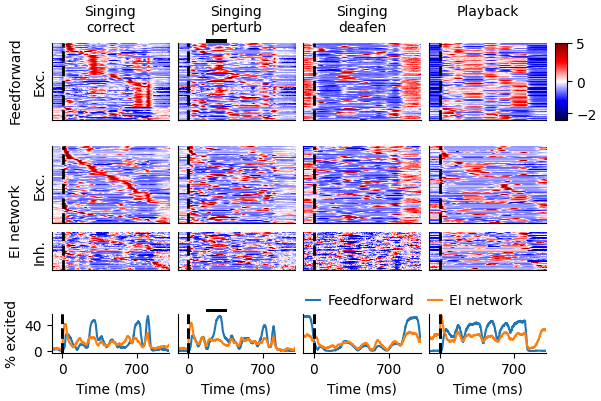

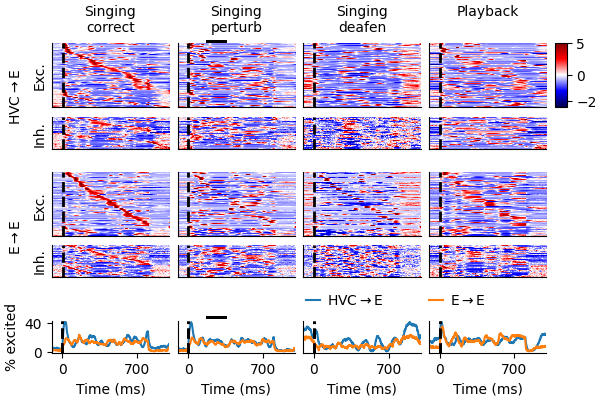

In [17]:
t0 = int(np.round(aud_real['pert_t0'].min(), -1)) + T_pre
t1 = int(np.round(aud_real['pert_t1'].max(), -1)) + T_pre + 100

ks = ('ctrl', 'pert_strong', 'deaf', 'playback')
titles = ['Singing\ncorrect', 'Singing\nperturb', 'Singing\ndeafen', 'Playback\n']
fig, ax = plot_raster([res[k][0][i] for k in ks], [res[k][1][i] for k in ks], 
                      'Feedforward', 'EI network', NE, titles, 
                      0, T_pre+T_rend, T_pre, t0, t1)
fig.savefig('svg/compare_EI_FF_%s.svg' % postfix, transparent=True)

fig, ax = plot_raster([res[k][1][i] for k in ks], [res[k][2][i] for k in ks], 
                      r'HVC$\to$E'+' '*8, r'E$\to$E'+' '*8, NE, titles, 
                      0, T_pre+T_rend, T_pre, t0, t1)
fig.savefig('svg/supplementary/compare_EI_EIrec_%s.svg' % postfix, transparent=True)